<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/Inceptiontry2_HQ_1811.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dropblock


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d')
checkpoint_folder = f'/content/drive/My Drive/FYP/ModelCheckpointsHQltst_Inception_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

transform_val_test = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])


# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use Pre-trained Inception v3 model and modify it for binary classification
class InceptionV3ModifiedWithAttention(nn.Module):
    def __init__(self):
        super(InceptionV3ModifiedWithAttention, self).__init__()
        self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

        # Spatial Attention
        self.spatial_attention = SpatialAttention(input_channels=192)

        # Replace the final fully connected layer for binary classification
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        # Initial layers
        x = self.inception.Conv2d_1a_3x3(x)
        x = self.inception.Conv2d_2a_3x3(x)
        x = self.inception.Conv2d_2b_3x3(x)
        x = self.inception.Conv2d_3b_1x1(x)
        x = self.inception.Conv2d_4a_3x3(x)

        # Apply spatial attention before Mixed_5b
        x = self.spatial_attention(x)

        # Continue through Inception blocks
        x = self.inception.Mixed_5b(x)
        x = self.inception.Mixed_5c(x)
        x = self.inception.Mixed_5d(x)

        # Aux classifier and main output
        if self.training:
            aux, x = self.inception(x)
            return aux, x
        else:
            x = self.inception(x)
            return x





class SpatialAttention(nn.Module):
    def __init__(self, input_channels):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)  # Spatial attention maps
        self.sigmoid = nn.Sigmoid()

        # Use a 1x1 conv to restore original channels
        self.channel_restore = nn.Conv2d(input_channels, input_channels, kernel_size=1, bias=False)

    def forward(self, x):
        # Compute max and mean along the channel axis
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        mean_out = torch.mean(x, dim=1, keepdim=True)

        # Concatenate along channel axis
        spatial_attention = torch.cat([max_out, mean_out], dim=1)  # [batch_size, 2, height, width]
        spatial_attention = self.conv(spatial_attention)  # [batch_size, 1, height, width]
        spatial_attention = self.sigmoid(spatial_attention)

        # Multiply attention map with the input
        x = x * spatial_attention

        # Restore original channels
        return self.channel_restore(x)



# Initialize the Inception model
model = InceptionV3ModifiedWithAttention()

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Early stopping class (commented out for now)
# class EarlyStopping:
#     def __init__(self, patience=5, verbose=False):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_acc = None
#         self.early_stop = False

#     def __call__(self, val_acc, model, folder_path):
#         if self.best_acc is None:
#             self.best_acc = val_acc
#             self.save_model(model, folder_path)
#         elif val_acc <= self.best_acc:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 if self.verbose:
#                     print("Early stopping triggered!")
#                 self.early_stop = True
#         else:
#             self.best_acc = val_acc
#             self.save_model(model, folder_path)
#             self.counter = 0

#     def save_model(self, model, folder_path):
#         model_save_path = os.path.join(folder_path, f"best_model_inception_{date_str}.pth")
#         torch.save(model.state_dict(), model_save_path)
#         print(f"Best model saved with accuracy: {self.best_acc:.4f}% at {model_save_path}")

# Training loop with learning rate scheduler
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            aux_outputs, outputs = model(inputs)  # Inception requires auxiliary outputs
            loss = criterion(outputs, labels) + 0.4 * criterion(aux_outputs, labels)  # 0.4 weight on aux loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print the loss per epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.6f}")

        # Validate the model and check accuracy
        val_acc = validate(model, val_loader, criterion)
        val_accuracies.append(val_acc)
        scheduler.step(val_acc)

        # Save the best model if the accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_path = os.path.join(checkpoint_folder, f"best_model_inception_{date_str}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_acc:.2f}% at {best_model_path}")

    # Plot training loss and validation accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save the final model
    final_model_path = os.path.join(checkpoint_folder, f"final_model_inception_{date_str}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

# Validation loop returning accuracy
def validate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy

# Test function to evaluate on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader):.6f}, Test Accuracy: {accuracy:.2f}%')

# Run the full code sequence

# Step 1: Train the model with learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# Step 2: Evaluate the model on the test set
test(model, test_loader, criterion)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms, models
# from torch.utils.data import DataLoader, random_split
# import numpy as np
# import random
# import optuna
# from optuna.samplers import TPESampler

# # Mount Google Drive to save and load the model (if using Google Colab)
# from google.colab import drive
# drive.mount('/content/drive')

# # Set random seeds for reproducibility
# torch.manual_seed(42)
# np.random.seed(42)
# random.seed(42)

# # Define the InceptionV3Modified class for binary classification
# class InceptionV3Modified(nn.Module):
#     def __init__(self):
#         super(InceptionV3Modified, self).__init__()
#         self.inception = models.inception_v3(weights='IMAGENET1K_V1')
#         # Replace the final fully connected layer to output 2 classes
#         num_ftrs = self.inception.fc.in_features
#         self.inception.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(num_ftrs, 2)
#         )

#     def forward(self, x):
#         if self.training:
#             aux, x = self.inception(x)
#             return aux, x
#         else:
#             return self.inception(x)

# # Data transformations and loading
# transform_train = transforms.Compose([
#     transforms.Resize((299, 299)),   # Inception v3 expects 299x299 input size
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
# ])

# transform_val_test = transforms.Compose([
#     transforms.Resize((299, 299)),
#     transforms.ToTensor(),
# ])

# # Define paths for training and validation datasets
# data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/train'
# test_data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/test'
# train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
# test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# # Split the dataset into 80% training and 20% validation
# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# # Validation function for accuracy
# def validate(model, loader, criterion):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in loader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     accuracy = 100 * correct / total
#     return accuracy

# # Define the Objective Function for Hyperparameter Tuning
# def objective(trial):
#     # Hyperparameter suggestions
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
#     batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
#     weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
#     aux_weight = trial.suggest_float("aux_weight", 0.1, 0.5)

#     # Initialize model
#     model = InceptionV3Modified()
#     criterion = nn.CrossEntropyLoss()

#     # Optimizer selection and configuration
#     if optimizer_name == "Adam":
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     else:
#         momentum = trial.suggest_float("momentum", 0.7, 0.99)
#         optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

#     # Scheduler
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

#     # Data Loaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     # Short training loop for hyperparameter tuning
#     best_val_acc = 0.0
#     for epoch in range(5):  # Using fewer epochs for faster tuning
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             aux_outputs, outputs = model(inputs)
#             loss = criterion(outputs, labels) + aux_weight * criterion(aux_outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         # Validate and track best validation accuracy
#         val_acc = validate(model, val_loader, criterion)
#         scheduler.step(val_acc)
#         best_val_acc = max(best_val_acc, val_acc)

#         # Early stopping for poor-performing trials
#         trial.report(val_acc, epoch)
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#     return best_val_acc

# # Run Optuna Study
# sampler = TPESampler()
# study = optuna.create_study(direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=20)

# # Print best parameters and results
# best_params = study.best_params
# print("Best hyperparameters:", best_params)
# print("Best validation accuracy:", study.best_value)


ModuleNotFoundError: No module named 'optuna'

# Use this in terminal:
# %pip install optuna-dashboard
# %optuna-dashboard sqlite:///optuna_study.db

In [ ]:
# # Extract best parameters from the Optuna study
# final_batch_size = best_params['batch_size']
# final_learning_rate = best_params['learning_rate']
# final_optimizer_name = best_params['optimizer']
# final_weight_decay = best_params['weight_decay']
# final_aux_weight = best_params['aux_weight']

# # Initialize model with best parameters
# model = InceptionV3Modified()
# criterion = nn.CrossEntropyLoss()

# # Configure optimizer with best parameters
# if final_optimizer_name == "Adam":
#     optimizer = optim.Adam(model.parameters(), lr=final_learning_rate, weight_decay=final_weight_decay)
# else:
#     optimizer = optim.SGD(model.parameters(), lr=final_learning_rate, momentum=best_params.get("momentum", 0.9), weight_decay=final_weight_decay)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
# train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=final_batch_size, shuffle=False)

# # Full training loop using best parameters
# def train_with_best_params(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
#     best_acc = 0.0
#     train_losses, val_accuracies = [], []

#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             aux_outputs, outputs = model(inputs)
#             loss = criterion(outputs, labels) + final_aux_weight * criterion(aux_outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         # Validate and record accuracy
#         val_acc = validate(model, val_loader, criterion)
#         scheduler.step(val_acc)
#         train_losses.append(running_loss / len(train_loader))
#         val_accuracies.append(val_acc)
#         print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_losses[-1]:.6f}, Val Accuracy: {val_acc:.2f}%")

#         # Save best model
#         if val_acc > best_acc:
#             best_acc = val_acc
#             best_model_path = os.path.join(checkpoint_folder, f"best_model_inception_{date_str}.pth")
#             torch.save(model.state_dict(), best_model_path)
#             print(f"New best model saved with accuracy: {best_acc:.2f}% at {best_model_path}")

#     # Plot training loss and validation accuracy
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='Training Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training Loss')
#     plt.grid(True)

#     plt.subplot(1, 2, 2)
#     plt.plot(val_accuracies, label='Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy (%)')
#     plt.title('Validation Accuracy')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Train with the best hyperparameters from Optuna
# train_with_best_params(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 174MB/s] 
<ipython-input-1-aa299babbdef>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle m

Model loaded from /content/drive/My Drive/FYP/ModelCheckpointsHQltst_Inception_20241101/final_model_inception_20241101.pth


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


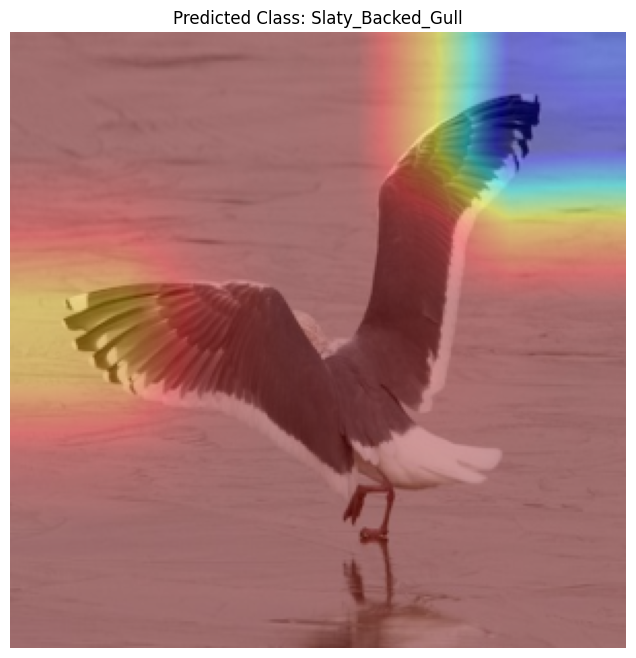

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Mount Google Drive to load the model and image
from google.colab import drive
drive.mount('/content/drive')

# Path to the saved model and test image
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQltst_Inception_20241101/final_model_inception_20241101.pth'
image_path = '/content/480 (40).jpeg'  # Update with actual test image path

# Define image transformation to match model input
transform = transforms.Compose([
    transforms.Resize((299, 299)),   # Inception v3 expects 299x299 input size
    transforms.ToTensor(),
])

# Define the modified Inception model with your custom fully connected layer
class InceptionV3Modified(nn.Module):
    def __init__(self):
        super(InceptionV3Modified, self).__init__()
        self.inception = models.inception_v3(pretrained=True)
        # Replace the final fully connected layer to output 2 classes
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        if self.training:
            aux, x = self.inception(x)
            return aux, x
        else:
            return self.inception(x)

# Load the saved model weights
model = InceptionV3Modified()
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()

print(f"Model loaded from {checkpoint_path}")

# Class names as per dataset
class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']  # Adjust based on your class order

# Function to preprocess and load a single image
def preprocess_image(image_path):
    """Load an image and apply transformations."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Function to generate Grad-CAM heatmap and show predicted class
def generate_gradcam_inception(model, image_tensor, target_layer, class_names):
    model.eval()
    features = []
    grads = []

    # Define hooks to capture feature maps and gradients
    def save_features_hook(module, input, output):
        features.append(output)

    def save_grads_hook(module, grad_in, grad_out):
        grads.append(grad_out[0])

    # Register hooks to the target layer
    hook1 = target_layer.register_forward_hook(save_features_hook)
    hook2 = target_layer.register_backward_hook(save_grads_hook)

    # Forward pass
    output = model(image_tensor)
    predicted_class_idx = output.argmax().item()
    predicted_class = class_names[predicted_class_idx]

    # Backward pass to get gradients
    model.zero_grad()
    class_loss = output[0, predicted_class_idx]
    class_loss.backward()

    # Process gradients and feature maps
    gradient = grads[0].cpu().data.numpy()[0]
    feature_map = features[0].cpu().data.numpy()[0]

    # Calculate Grad-CAM
    weights = np.mean(gradient, axis=(1, 2))  # Global average pooling of gradients
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * feature_map[i]

    cam = np.maximum(cam, 0)  # ReLU to remove negative values
    cam = cv2.resize(cam, (image_tensor.shape[3], image_tensor.shape[2]))  # Resize to match image dimensions
    cam -= np.min(cam)
    cam /= np.max(cam)  # Normalize between 0 and 1

    # Convert original image for heatmap overlay
    original_image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    original_image = (original_image - np.min(original_image)) / (np.max(original_image) - np.min(original_image))

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = 0.4 * heatmap + 0.6 * original_image

    # Show the image with the predicted class name
    plt.figure(figsize=(8, 8))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()

    # Remove hooks
    hook1.remove()
    hook2.remove()

# Set the target layer for Grad-CAM
target_layer = model.inception.Mixed_7c  # Last convolutional layer in Inception v3

# Preprocess the image
image_tensor = preprocess_image(image_path)

# Generate Grad-CAM for the specific image and show the predicted class
generate_gradcam_inception(model, image_tensor, target_layer, class_names)


<ipython-input-8-ace1e20e4102>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Model loaded from /content/drive/My Drive/FYP/ModelCheckpointsHQltst_Inception_20241101/final_model_inception_20241101.pth


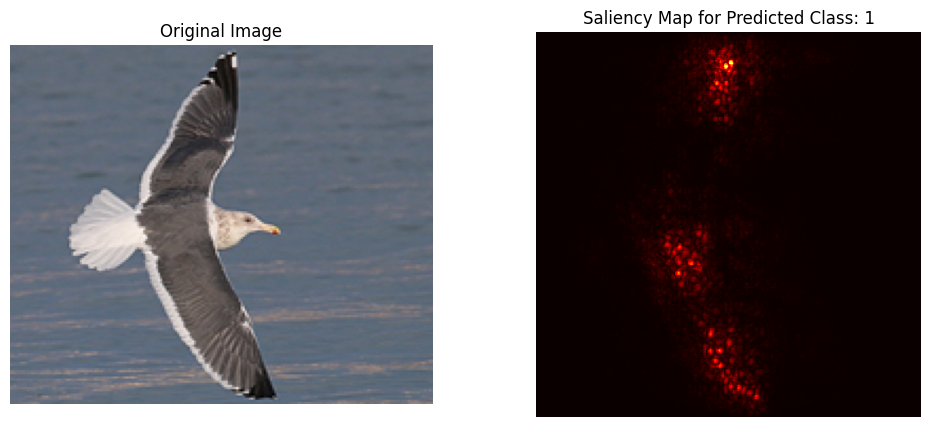

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load your modified Inception model
class InceptionV3Modified(nn.Module):
    def __init__(self):
        super(InceptionV3Modified, self).__init__()
        self.inception = models.inception_v3(pretrained=True)
        # Replace the final fully connected layer to output 2 classes
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        if self.training:
            aux, x = self.inception(x)
            return aux, x
        else:
            return self.inception(x)

# Load the trained model
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQltst_Inception_20241101/final_model_inception_20241101.pth'
model = InceptionV3Modified()
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()
print(f"Model loaded from {checkpoint_path}")

# Define image transformation to match model input size
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 expects 299x299 input size
    transforms.ToTensor(),
])

# Load and preprocess an image
image_path = '/content/12122592614_c72807ccf6_k.jpg'  # Update with your test image path
image = Image.open(image_path).convert("RGB")
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Set requires_grad to True for the saliency map
input_image.requires_grad_()

# Forward pass
output = model(input_image)
target_class = output.argmax(dim=1)  # Get the top predicted class

# Backward pass to calculate gradients of target class with respect to input
model.zero_grad()
output[0, target_class].backward()

# Calculate saliency by taking the absolute value of the gradients
saliency = input_image.grad.data.abs()
saliency, _ = torch.max(saliency, dim=1)  # Take the max across color channels
saliency = saliency.squeeze().cpu().numpy()  # Convert to numpy for plotting

# Normalize the saliency map for better visualization
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

# Display the original image and saliency map
plt.figure(figsize=(12, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(np.array(image))
plt.title("Original Image")
plt.axis('off')

# Saliency Map
plt.subplot(1, 2, 2)
plt.imshow(saliency, cmap='hot')
plt.title(f"Saliency Map for Predicted Class: {target_class.item()}")
plt.axis('off')

plt.show()
